<a href="https://colab.research.google.com/github/devrock20/Spotify/blob/main/Spotify.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Index**
----


1.  [Imports and Tools](#1) <br>
    1-A. [Imports](#1-A) <br>
    1-B. [Progress bar display](#1-B) <br>
    1-C. [Requests manager](#1-C) <br>
2.   [Data Loading/Collection](#2) <br>
    2-A. [Gather data from the Spotify API](#2-A) <br>
    2-B. [Load dataset and show first 5 rows](#2-B) <br>
3.   [Data Cleaning](#3) <br>
    3-A. [Fix release dates](#3-A) <br>
    3-B. [Load covid dataset for a specific country](#3-B) <br>
4.   [Show missing values](#4) <br>
    4-A. [Plot missing values per country by week charted](#4-A) <br>
    4-B. [Plot missing values for the current country for each position missing in every week charted](#4-B) <br>
5.   [Data Visualization](#5) <br>
    5-A. [Genres](#5-A) <br>
    5-B. [Song features](#5-B) <br>
    5-C. [Song's release date](#5-C) <br>









<a name="1"></a>
# 1. Imports and Tools
---



<a name="1-A"></a>
### 1-A. Imports

In [ ]:
import json
import os
import re
import time
from datetime import date, timedelta, datetime

from matplotlib import pyplot as plt
import missingno as msno
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.preprocessing import MultiLabelBinarizer
import warnings

# Turns off warnings for pandas/numpy
warnings.simplefilter(action='ignore', category=FutureWarning)

# Downloads all necessary files
if not os.path.exists('spotify_dataset.feather'):
    !gdown --id 1yki5ICaRcB5KY4psE4qVzqyGXxMGhFhE
if not os.path.exists('spotify_genre.feather'):
    !gdown --id 1DnHntMvoTZSnQhM12tBzdKYmTtSg7AB2
if not os.path.exists('spotify_dataset_us.csv'):
    !gdown --id 1lBMhg2_NBwD2NOM6VFLWX1N_TAPLd5oS
if not os.path.exists('owid-covid-data.csv'):
    !gdown --id 16QKydmHUopDbtkMAlK0v0OmJwLZFePwx

<a name="1-B"></a>
### 1-B. Progress bar display
This creates a loading bar to show progress for processes involving downloading/transforming data.

In [ ]:
#@title  { display-mode: "form" }
from IPython.display import HTML, display

def progress(value, max=100):
    return HTML("""
        <progress
            value='{value}'
            max='{max}',
            style='width: 100%'
        >
            {value}
        </progress>
    """.format(value=value, max=max))


<a name="1-C"></a>
### 1-C. Requests manager
In order to prevent an API request from failing over a rate limit, we use this tool to retry the request on failure. 

In [ ]:
#@title  { display-mode: "form" }
import requests
from requests.adapters import HTTPAdapter
from requests.packages.urllib3.util.retry import Retry

retry_strategy = Retry(
    total=5,
    backoff_factor=1,
    status_forcelist=[429, 500, 502, 503, 504],
    method_whitelist=["HEAD", "GET", "OPTIONS"]
)
adapter = HTTPAdapter(max_retries=retry_strategy)
http = requests.Session()
http.mount("https://", adapter)
http.mount("http://", adapter)


<a name="2"></a>
# 2. Data Loading/Collection
---

<a name="2-A"></a>
### 2-A. Gather data from the Spotify API (this takes a long time)
We need to use Spotify's API to collect information about a song such as its release date, genres, and audio features. Due to the time consuming nature of this code, we only have to run it if the result for this method was not already preloaded. 

In [ ]:
#@title  { display-mode: "form" }
if not os.path.exists("spotify_dataset.feather"):
    # The user's spotifty api token 
    token = "<insert_token_here>"
    # read the data collected from spotify's top charts
    df = pd.read_csv("spotify_charts_dataset.csv", index_col=0)
    # rename the id column to song id
    df["song_id"] = df.pop("id")
    # remove songs with unknown titles
    df = df[df.song_id != "#"]
    # remove the track name (this is collected by the spotify api)
    df.pop("track")
    # get a unique list of song ids
    song_ids = df["song_id"].unique().tolist()
    # list of audio features to grab
    audio_feature_cols = [
        "song_id", "danceability", "energy", "key", "loudness", "mode", "speechiness",
        "acousticness", "instrumentalness", "liveness", "valence", "tempo",
        "duration_ms", "time_signature"
    ]
    afdf = pd.DataFrame()
    gdf = pd.DataFrame()
    # initiate progress bar
    out = display(progress(0, 100), display_id=True)
    i = 0
    # loop through unique song ids
    while i < len(song_ids):
        # update progress bar
        out.update(progress(i / len(song_ids) * 100, 100))
        # select 50 or less songs
        songs = song_ids[i : min(50 + i, len(song_ids))]
        # request audio feature data for the selected list of songs
        url = f'https://api.spotify.com/v1/audio-features?ids={",".join(songs)}'
        req = http.get(
            url,
            headers={
                "Accept": "application/json",
                "Content-Type": "application/json",
                "Authorization": f"Bearer {token}",
            },
        )
        try:
            # store audio feature data
            data = req.json()["audio_features"]

        except:
            # if token is invalid or expired, request a new one
            if 'error' in req.json() and int(req.json()['error']['status']) == 401:
                token = input("Input new token: ")
                continue
            # print other broken data or requests
            print(req.json())
            print(url)
            break
        # loop through the list of songs' audio features
        for j, item in enumerate(data):
            # if a song is missing audio features then set it's features to None
            if item is None:
                data[j] = {}
                # update song id to match original id
                data[j]["song_id"] = songs[j]
                # set audio features to None
                for col in audio_feature_cols[1:]:
                    data[j][col] = None
                continue
            # update song id to match original id
            item["song_id"] = songs[j]
        # store audio feature data in a dataframe
        audio_features_df = pd.DataFrame(data)[audio_feature_cols]
        # request track data for selected list of songs
        url = f'https://api.spotify.com/v1/tracks?ids={",".join(songs)}'
        req = http.get(
            url,
            headers={
                "Accept": "application/json",
                "Content-Type": "application/json",
                "Authorization": f"Bearer {token}",
            },
        )
        try:
            # store track data
            data = req.json()["tracks"]
        except:
            # if token is invalid or expired, request a new one
            if 'error' in req.json() and int(req.json()['error']['status']) == 401:
                token = input("Input new token: ")
                continue
            # print other broken data or requests
            print(req.json())
            print(url)
            break
        # store track data in a dataframe
        track_df = pd.DataFrame(
            [
                {
                    "song_id": songs[j],
                    "track": item["name"],
                    "release_date": item["album"]["release_date"],
                    "artist_id": item["artists"][0]["id"],
                }
                for j, item in enumerate(data)
            ]
        )
        # merge the two dataframes
        combined_df = pd.merge(audio_features_df, track_df, on="song_id")
        # append the dataframe 
        afdf = afdf.append(combined_df, ignore_index=True)
        # update i value
        i += min(50, len(song_ids) - i)
    # get unique artists
    artist_ids = afdf["artist_id"].unique().tolist()
    genre_df = pd.DataFrame()
    i = 0
    # initiate progress bar
    out = display(progress(0, 100), display_id=True)
    # loop through unique artists
    while i < len(artist_ids):
        # update progress bar
        out.update(progress(i / len(artist_ids) * 100, 100))
        # select 15 or less aritsts
        artists = artist_ids[i : min(15 + i, len(artist_ids))]
         # request artist data for the selected list of artists
        req = http.get(
            f'https://api.spotify.com/v1/artists?ids={",".join(artists)}',
            headers={
                "Accept": "application/json",
                "Content-Type": "application/json",
                "Authorization": f"Bearer {token}",
            },
        )
        try:
            # store artist data
            data = req.json()["artists"]
        except:
            # if token is invalid or expired, request a new one
            if 'error' in req.json() and int(req.json()['error']['status']) == 401:
                token = input("Input new token: ")
                continue
            # print other broken data or requests
            print(req.json())
            print(url)
            break
        # loop through artists data
        for j, item in enumerate(data):
            # reset to original id
            item["id"] = artists[j]
            # store artist name
            item["artist"] = item["name"]
        # append artist and genre data
        genre_df = genre_df.append(data, ignore_index=True)[["id", "artist", "genres"]]
        # update i value
        i += min(15, len(artist_ids) - i)
    # rename id column to artist_id
    genre_df["artist_id"] = genre_df.pop("id")
    # merge the two dataframe 
    afdf = pd.merge(afdf, genre_df, on="artist_id")
    # join data back on the original dataframe
    df = pd.merge(df, afdf, on="song_id")
    # turn genres back into a string so it can be saved in a file
    df['genres'] = df['genres'].apply(lambda x: str(x))
    # save to file
    df.to_feather('spotify_dataset.feather')


<a name="2-B"></a>
### 2-B. Load dataset and show first 5 rows
There is a dropdown box that allows for the a certain country's spotify data to be selected. The data is then transformed to fit the needs of the notebook.

In [ ]:

#@title  { run: "auto", vertical-output: true, display-mode: "form" }
country = 'us' #@param ['us','all','global','ae', 'ar', 'at', 'au', 'be', 'bg', 'bo', 'br', 'ca', 'ch', 'cl', 'co', 'cr', 'cy', 'cz', 'de', 'dk', 'do', 'ec', 'ee', 'eg', 'es', 'fi', 'fr', 'gb', 'gr', 'gt', 'hk', 'hn', 'hu', 'id', 'ie', 'il', 'in', 'is', 'it', 'jp', 'kr', 'lt', 'lu', 'lv', 'ma', 'mx', 'my', 'ni', 'nl', 'no', 'nz', 'pa', 'pe', 'ph', 'pl', 'pt', 'py', 'ro', 'ru', 'sa', 'se', 'sg', 'sk', 'sv', 'th', 'tr', 'tw', 'ua', 'uy', 'vn', 'za']
df = pd.read_feather('spotify_dataset.feather')
if not country == 'all':
    # select the specified country
    df = df[df.country == country]
    # convert str of list to list
    df['genres'] = df['genres'].apply(lambda x: eval(x))
# remove incomplete rows
df.dropna(inplace=True)
# shorten release_date to just the year
df['release_date'] = df['release_date'].apply(lambda x: x.split('-')[0])
# country is changed to region because it conflicts with the genre of country that we add as a field later on
df['region'] = df.pop('country')
# convert week_charted to datetime format
df['week_charted'] = pd.to_datetime(df['week_charted'])
# sort values into a readable format
df = df.sort_values(['region','week_charted', 'position']).reset_index(drop=True)
df.head()


,position,streams,week_charted,song_id,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature,track,release_date,artist_id,artist,genres,region
0,1,8618267,2016-12-23,343YBumqHu19cGoGARUTsd,0.928,0.481,9.0,-9.350,0.0,0.2870,0.105,0.000000,0.176,0.613,134.007,210937.0,4.0,Fake Love,2017,3TVXtAsR1Inumwj472S9r4,Drake,"[canadian hip hop, canadian pop, hip hop, rap,...",us
1,2,7946032,2016-12-23,4Km5HrUvYTaSUfiSGPJeQR,0.927,0.665,11.0,-5.313,1.0,0.2440,0.061,0.000000,0.123,0.175,127.076,343150.0,4.0,Bad and Boujee (feat. Lil Uzi Vert),2017,6oMuImdp5ZcFhWP0ESe6mG,Migos,"[atl hip hop, pop rap, rap, trap]",us
2,3,7738517,2016-12-23,5aAx2yezTd8zXrkmtKl66Z,0.681,0.594,7.0,-7.028,1.0,0.2820,0.165,0.000003,0.134,0.535,186.054,230453.0,4.0,Starboy,2016,1Xyo4u8uXC1ZmMpatF05PJ,The Weeknd,"[canadian contemporary r&b, canadian pop, pop]",us
3,4,6209336,2016-12-23,6fujklziTHa8uoM5OQSfIo,0.794,0.632,0.0,-6.163,1.0,0.0649,0.142,0.000000,0.128,0.355,145.926,291893.0,4.0,Black Beatles,2016,7iZtZyCzp3LItcw1wtPI3D,Rae Sremmurd,"[hip hop, melodic rap, mississippi hip hop, po...",us
4,5,5813157,2016-12-23,7BKLCZ1jbUBVqRi2FVlTVw,0.748,0.524,8.0,-5.599,1.0,0.0338,0.414,0.000000,0.111,0.661,95.010,244960.0,4.0,Closer,2016,69GGBxA162lTqCwzJG5jLp,The Chainsmokers,"[dance pop, edm, electropop, pop, pop dance, t...",us


<a name="3"></a>
# 3. Data Cleaning
----

There are a few cases where the release date on the song is incorrect and might point to a remastered version. This code will find the song's original release date so it can be used for visualization later. Be aware this takes a long time so you should only run this for countries that already have the result preloaded.

<a name="3-A"></a>
### 3-A. Fix release dates (this takes a long time)

In [ ]:
#@title  { display-mode: "form" }
fix_release_dates = True #@param {type:"boolean"}
# if the checkbox is true and not a file already exists with corrected release dates, then create a new file with corrected release dates
if fix_release_dates and not os.path.exists(f'spotify_dataset_{country}.csv'):
    # keep only unique songs with the same song title and artist
    release_df = df.drop_duplicates(['track', 'artist'])
    i = 0
    # drop na values
    release_df.dropna(inplace=True)
    counter = 0
    token = "<insert_token_here>"
    # initate progress bar
    out = display(progress(0, len(release_df)), display_id=True)    
    # loop through unique songs
    while i < len(release_df): 
        # update progress bar
        out.update(progress(i , len(release_df)))
        # select a song
        song = release_df.iloc[i]
        # search for the real song using spotify's API
        url = f'https://api.spotify.com/v1/search'
        req = http.get(
            url,
            params={
                'q': song['track'] + ' ' + song['artist'],
                'type': 'track',
                'market': song['region']
            },
            headers={
                "Accept": "application/json",
                "Content-Type": "application/json",
                "Authorization": f"Bearer {token}",
            },
        )
        try:
            # store the first result from the search
            data = req.json()["tracks"]["items"][0]
        except:
            # if token is invalid or expired, request a new one
            if 'error' in req.json() and int(req.json()['error']['status']) == 401:
                token = input("Input new token: ")
                continue
            # otherwise skip song
            i += 1
            continue
        # if the song has a different release date
        if data['album']['release_date'].split('-')[0] != song['release_date']:
            # if the song has the same name and artist
            if data['artists'][0]['name'] == song['artist'] and data['name'] == song['track']:
                # replace the release date with the smaller year
                release_df.loc[release_df.song_id == song.song_id, 'release_date'] = min(int(data['album']['release_date'].split('-')[0]), int(song['release_date']))
                counter += 1
        i += 1
    # join the dataframes
    release_df = df[df.columns.drop('release_date')].merge(release_df[['release_date', 'track', 'artist']], on=['track', 'artist'])
    # write to file
    release_df.to_csv(f'spotify_dataset_{country}.csv')
    # delete dataframe to save memory
    del release_df
# if the updated release date file exists then replace the dataframe with the corrected one
if os.path.exists(f'spotify_dataset_{country}.csv') or fix_release_dates:
    df = df[df.columns.drop('release_date')].merge(pd.read_csv(f'spotify_dataset_{country}.csv')[['release_date', 'track', 'artist']].drop_duplicates(['track', 'artist']), on=['track', 'artist'])
    

<a name="3-B"></a>
### 3-B. Load covid dataset for a specific country
There is an option to select what country will be used to load the covid data .

In [ ]:
#@title Load covid dataset for a specific country { run: "auto", display-mode: "form" }
covid_country = "United States" #@param ["United States", "Afghanistan", "Africa", "Albania", "Algeria", "Andorra", "Angola", "Anguilla", "Antigua and Barbuda", "Argentina", "Armenia", "Aruba", "Asia", "Australia", "Austria", "Azerbaijan", "Bahamas", "Bahrain", "Bangladesh", "Barbados", "Belarus", "Belgium", "Belize", "Benin", "Bermuda", "Bhutan", "Bolivia", "Bonaire Sint Eustatius and Saba", "Bosnia and Herzegovina", "Botswana", "Brazil", "British Virgin Islands", "Brunei", "Bulgaria", "Burkina Faso", "Burundi", "Cambodia", "Cameroon", "Canada", "Cape Verde", "Cayman Islands", "Central African Republic", "Chad", "Chile", "China", "Colombia", "Comoros", "Congo", "Cook Islands", "Costa Rica", "Cote d'Ivoire", "Croatia", "Cuba", "Curacao", "Cyprus", "Czechia", "Democratic Republic of Congo", "Denmark", "Djibouti", "Dominica", "Dominican Republic", "Ecuador", "Egypt", "El Salvador", "Equatorial Guinea", "Eritrea", "Estonia", "Eswatini", "Ethiopia", "Europe", "European Union", "Faeroe Islands", "Falkland Islands", "Fiji", "Finland", "France", "French Polynesia", "Gabon", "Gambia", "Georgia", "Germany", "Ghana", "Gibraltar", "Greece", "Greenland", "Grenada", "Guatemala", "Guernsey", "Guinea", "Guinea-Bissau", "Guyana", "Haiti", "Honduras", "Hong Kong", "Hungary", "Iceland", "India", "Indonesia", "International", "Iran", "Iraq", "Ireland", "Isle of Man", "Israel", "Italy", "Jamaica", "Japan", "Jersey", "Jordan", "Kazakhstan", "Kenya", "Kiribati", "Kosovo", "Kuwait", "Kyrgyzstan", "Laos", "Latvia", "Lebanon", "Lesotho", "Liberia", "Libya", "Liechtenstein", "Lithuania", "Luxembourg", "Macao", "Madagascar", "Malawi", "Malaysia", "Maldives", "Mali", "Malta", "Marshall Islands", "Mauritania", "Mauritius", "Mexico", "Micronesia (country)", "Moldova", "Monaco", "Mongolia", "Montenegro", "Montserrat", "Morocco", "Mozambique", "Myanmar", "Namibia", "Nauru", "Nepal", "Netherlands", "New Caledonia", "New Zealand", "Nicaragua", "Niger", "Nigeria", "Niue", "North America", "North Macedonia", "Northern Cyprus", "Norway", "Oceania", "Oman", "Pakistan", "Palau", "Palestine", "Panama", "Papua New Guinea", "Paraguay", "Peru", "Philippines", "Pitcairn", "Poland", "Portugal", "Qatar", "Romania", "Russia", "Rwanda", "Saint Helena", "Saint Kitts and Nevis", "Saint Lucia", "Saint Vincent and the Grenadines", "Samoa", "San Marino", "Sao Tome and Principe", "Saudi Arabia", "Senegal", "Serbia", "Seychelles", "Sierra Leone", "Singapore", "Sint Maarten (Dutch part)", "Slovakia", "Slovenia", "Solomon Islands", "Somalia", "South Africa", "South America", "South Korea", "South Sudan", "Spain", "Sri Lanka", "Sudan", "Suriname", "Sweden", "Switzerland", "Syria", "Taiwan", "Tajikistan", "Tanzania", "Thailand", "Timor", "Togo", "Tokelau", "Tonga", "Trinidad and Tobago", "Tunisia", "Turkey", "Turkmenistan", "Turks and Caicos Islands", "Tuvalu", "Uganda", "Ukraine", "United Arab Emirates", "United Kingdom", "United States", "Uruguay", "Uzbekistan", "Vanuatu", "Vatican", "Venezuela", "Vietnam", "Wallis and Futuna", "World", "Yemen", "Zambia", "Zimbabwe"]
# read from csv file
cdf= pd.read_csv('owid-covid-data.csv')
# select the current country
cdf = cdf[cdf.location == covid_country]
# convert the date from string to datetime
cdf['date'] = pd.to_datetime(cdf['date'])
# store ordinal value of the date
cdf['week_date_ord'] = cdf['date'].apply(lambda date: date.toordinal())
# set important features that have NaN values to 0
cdf.iloc[[0], [cdf.columns.get_loc(x) for x in ['new_cases', 'total_deaths', 'new_deaths', 'new_vaccinations', 'people_fully_vaccinated_per_hundred']]] = 0
# forward fill NaN values
cdf = cdf.fillna(method='ffill')
# show first 5 values
cdf.head()

,iso_code,continent,location,date,total_cases,new_cases,new_cases_smoothed,total_deaths,new_deaths,new_deaths_smoothed,total_cases_per_million,new_cases_per_million,new_cases_smoothed_per_million,total_deaths_per_million,new_deaths_per_million,new_deaths_smoothed_per_million,reproduction_rate,icu_patients,icu_patients_per_million,hosp_patients,hosp_patients_per_million,weekly_icu_admissions,weekly_icu_admissions_per_million,weekly_hosp_admissions,weekly_hosp_admissions_per_million,new_tests,total_tests,total_tests_per_thousand,new_tests_per_thousand,new_tests_smoothed,new_tests_smoothed_per_thousand,positive_rate,tests_per_case,tests_units,total_vaccinations,people_vaccinated,people_fully_vaccinated,total_boosters,new_vaccinations,new_vaccinations_smoothed,total_vaccinations_per_hundred,people_vaccinated_per_hundred,people_fully_vaccinated_per_hundred,total_boosters_per_hundred,new_vaccinations_smoothed_per_million,stringency_index,population,population_density,median_age,aged_65_older,aged_70_older,gdp_per_capita,extreme_poverty,cardiovasc_death_rate,diabetes_prevalence,female_smokers,male_smokers,handwashing_facilities,hospital_beds_per_thousand,life_expectancy,human_development_index,excess_mortality_cumulative_absolute,excess_mortality_cumulative,excess_mortality,excess_mortality_cumulative_per_million,week_date_ord
119380,USA,North America,United States,2020-01-22,1.0,0.0,NaN,0.0,0.0,NaN,0.003,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,0.0,NaN,NaN,0.0,332915074.0,35.608,38.3,15.413,9.732,54225.446,1.2,151.089,10.79,19.1,24.6,NaN,2.77,78.86,0.926,NaN,NaN,NaN,NaN,737446
119381,USA,North America,United States,2020-01-23,1.0,0.0,NaN,0.0,0.0,NaN,0.003,0.000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,0.0,NaN,NaN,0.0,332915074.0,35.608,38.3,15.413,9.732,54225.446,1.2,151.089,10.79,19.1,24.6,NaN,2.77,78.86,0.926,NaN,NaN,NaN,NaN,737447
119382,USA,North America,United States,2020-01-24,2.0,1.0,NaN,0.0,0.0,NaN,0.006,0.003,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,0.0,NaN,NaN,0.0,332915074.0,35.608,38.3,15.413,9.732,54225.446,1.2,151.089,10.79,19.1,24.6,NaN,2.77,78.86,0.926,NaN,NaN,NaN,NaN,737448
119383,USA,North America,United States,2020-01-25,2.0,0.0,NaN,0.0,0.0,NaN,0.006,0.000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,0.0,NaN,NaN,0.0,332915074.0,35.608,38.3,15.413,9.732,54225.446,1.2,151.089,10.79,19.1,24.6,NaN,2.77,78.86,0.926,NaN,NaN,NaN,NaN,737449
119384,USA,North America,United States,2020-01-26,5.0,3.0,NaN,0.0,0.0,NaN,0.015,0.009,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,0.0,NaN,NaN,0.0,332915074.0,35.608,38.3,15.413,9.732,54225.446,1.2,151.089,10.79,19.1,24.6,NaN,2.77,78.86,0.926,-9154.7,-3.68,-3.08,-27.498605,737450


Not all of the countries from the spotify dataset have logged top charted songs for each week up until 2016, so this chart will show which weeks are missing.

<a name="4"></a>
# 4. Showing Missing Values
---

<a name="4-A"></a>
### 4-A. Plot missing values per country by week charted
This is to show that spotify has not tracked data for every country since 2016, so it would make sense to have some values missing.

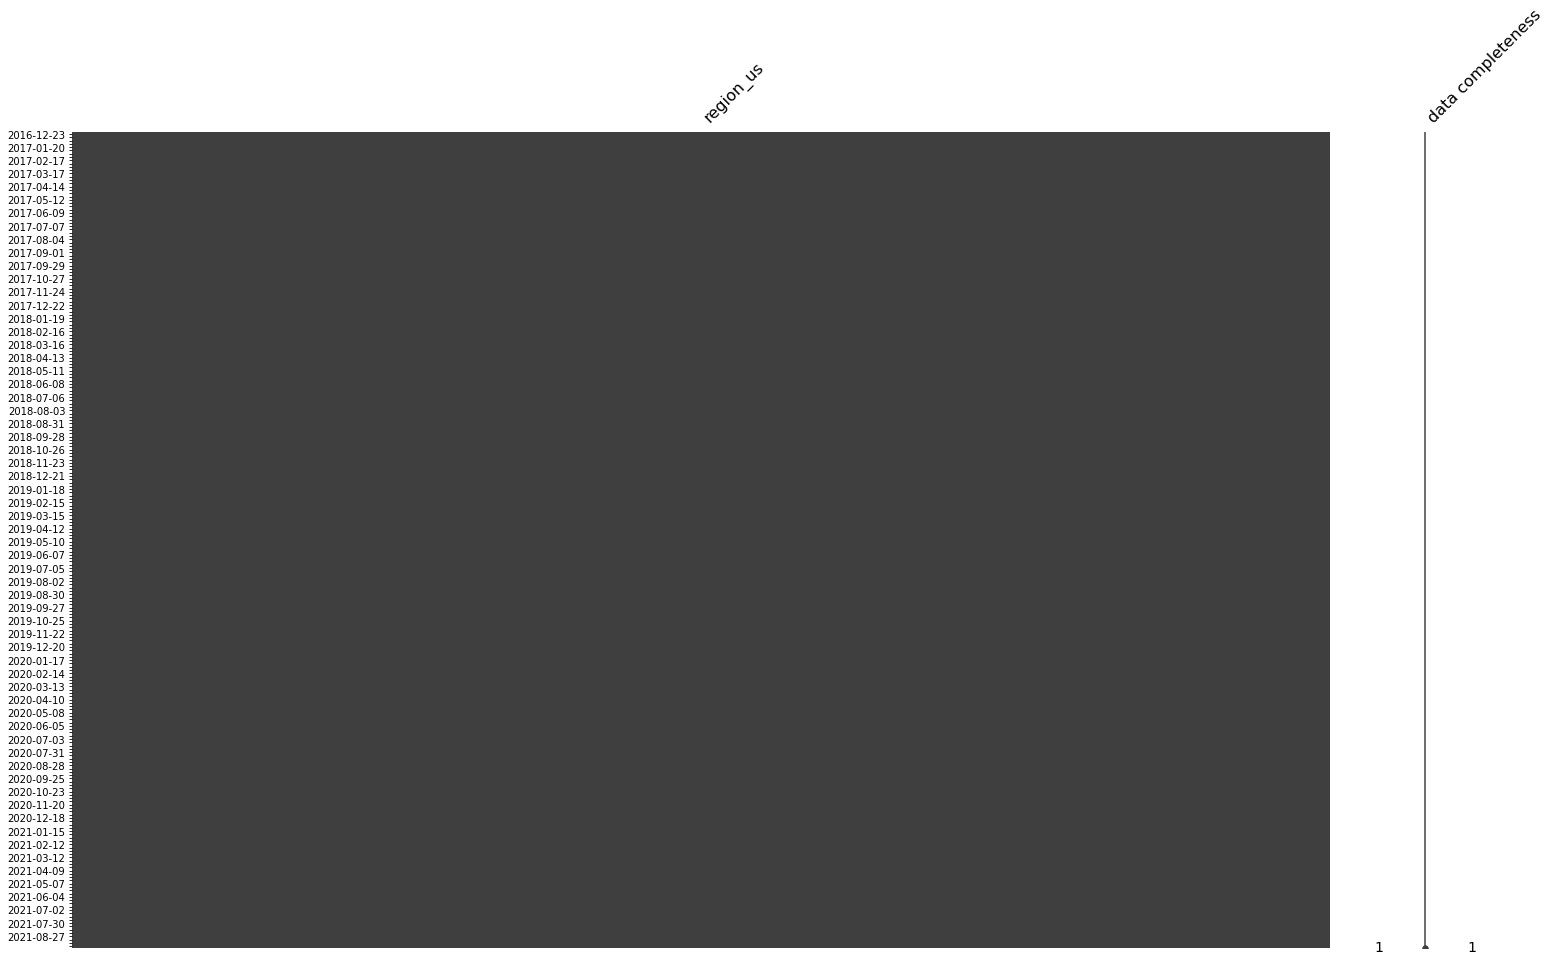

In [ ]:
#@title  { vertical-output: true, display-mode: "form" }

# shape the data to show missing values for each week
y = pd.get_dummies(df.region, prefix='region')
region_df = pd.concat([df[['week_charted']], y], axis=1)
region_df = region_df.groupby(by='week_charted', axis=0).sum()
region_df = region_df.reindex(pd.date_range('2016-12-23', max(df.week_charted.dt.date),freq='W-FRI'), method=None)
region_df = region_df.apply(lambda x: x.apply(lambda y: None if y == 0 else y))
# graph missing values 
ax = msno.matrix(region_df, figsize=(25,15),labels=True)
# add tick labels at every 4 ticks
ax.set_yticks(range(len(region_df.index.unique())))
yticklabels = pd.date_range(region_df.index[0],region_df.index[-1], freq='W-FRI').map(lambda t: t.strftime('%Y-%m-%d')).tolist()
yticklabels[1::4] = map(lambda x: '', yticklabels[1::4])
yticklabels[2::4] = map(lambda x: '', yticklabels[2::4])
yticklabels[3::4] = map(lambda x: '', yticklabels[3::4])
ax.set_yticklabels(yticklabels, fontsize=10)
ax.yaxis.set_ticks_position('left')

<a name="4-B"></a>
### 4-B. Plot missing values for the current country for each position missing in every week charted
This graph shows where missing songs are in each week based on position in the week. It helps to click on the graph for a close up view. Values would be missing here if Spotify's top charts dataset did not have data for some songs. 

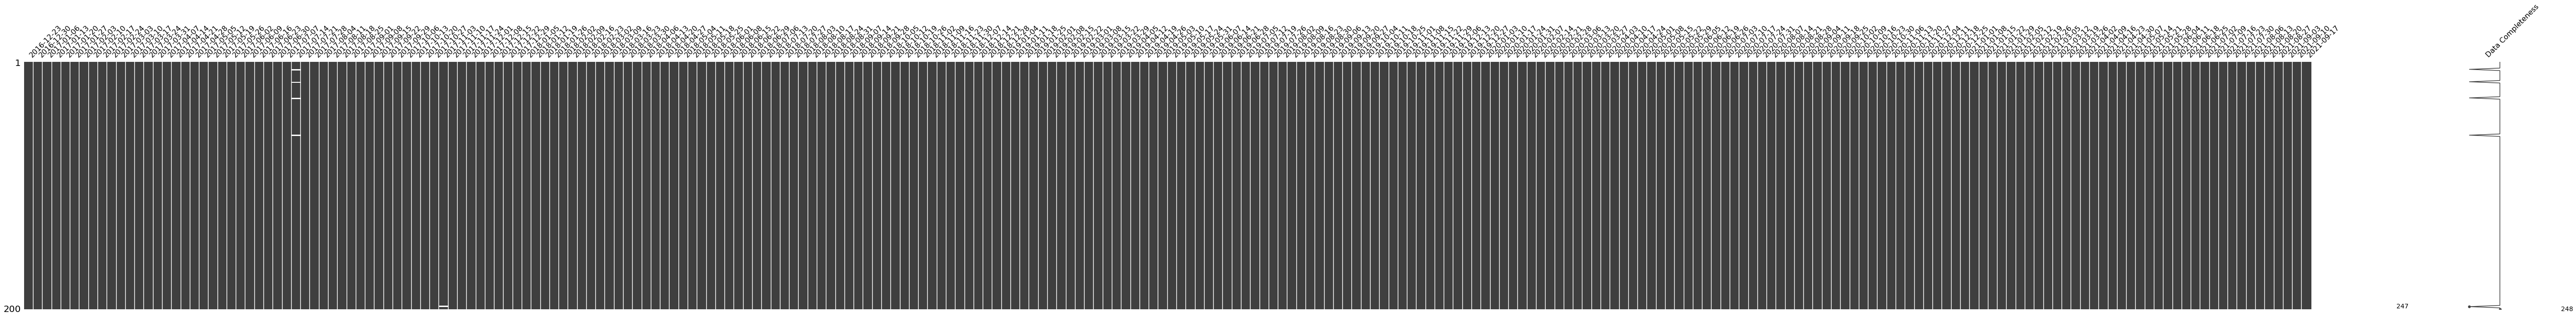

In [ ]:
#@title  { vertical-output: true, display-mode: "form" }
# only show this if not all countries are selected
if country != 'all':
    # shape the data to show missing values for each song position for each week
    y = pd.get_dummies(df.week_charted.dt.date)
    region_df = pd.concat([df[['position']], y], axis=1)
    region_df = region_df.groupby(by='position', axis=0).sum()
    region_df = region_df.apply(lambda x: x.apply(lambda y: None if y == 0 else y))
    # graph missing values 
    msno.matrix(region_df, figsize=(100,10), labels=True)

<a name="5"></a>
# 5. Data Visualization
----

<a name="5-A"></a>
### 5-A. Genres

This code converts the genre to a multilabel version of a one-hot encoded matrix, then counts the number of times the genre has appeared based on week charted and region. The result has already been preloaded so there is no need to run it again. In order to run the original code, you will need 50+ GB of RAM which Colab does not offer in the free version. 

In [ ]:
#@title Generate a dataframe containing the count of each genre based on week charted and country { display-mode: "form" }
# if the genre dataframe doesn't already exist then generate it
if not os.path.exists('spotify_genre.feather'):
    # find all unique genres
    genre_set = set()
    df.drop_duplicates(subset = ["song_id"])['genres'].apply(lambda x: [genre_set.add(i) for i in x])
    genre_list = list(genre_set)
    # drop duplicate songs so we don't run them multiple times
    genre_df = df[['song_id', 'genres']].drop_duplicates(subset = ["song_id"])
    # multi label binarizer
    v = genre_df.genres.values
    l = [len(x) for x in v.tolist()]
    f, u = pd.factorize(np.concatenate(v))
    n, m = len(v), u.size
    i = np.arange(n).repeat(l)
    dummies = pd.DataFrame(
        np.bincount(i * m + f, minlength=n * m).reshape(n, m),
        genre_df.index, u, dtype='int8')
    # remove original genres field and add new columns for each genre
    genre_df = genre_df.drop('genres', 1).join(dummies)
    # join the two dataframes
    genre_df = df[['song_id', 'week_charted', 'region']].merge(genre_df, on='song_id', how='inner')
    # take the count of each genre for each week charted and genre
    genre_week_df = genre_df.groupby(by=['week_charted', 'region'], squeeze=True)[genre_list].apply(lambda x: np.sum(x).astype('uint8'))
    genre_data=[]
    # flatten the genre into a format compatiable with visualizations
    def genre_flatten(x):
        # loop through rows of the dataframe
        for i,item in enumerate(x):
            # extract the week charted, region, genre, and count and append it to a list
            genre_data.append([pd.to_datetime(x._name[0]),x._name[1],x.index[i],item])
    # apply the above function
    genre_week_df.apply(genre_flatten,axis=1)
    # create a dateframe from the collected data 
    genre_week_df = pd.DataFrame(data = genre_data, columns=['week_date','region','category','count'])    
    # get the ordinal form of the date
    genre_week_df['week_date_ord'] = data['week_date'].apply(lambda date: date.toordinal())
    # write to file
    genre_week_df.to_feather('spotify_genre.feather')
# if genre dataframe is already downloaded then load it
else:
    # read from file
    genre_week_df = pd.read_feather('spotify_genre.feather')
# reduce to selected country 
genre_week_df = genre_week_df[genre_week_df.region == country]

Select the top 15 categories that have the biggest difference in mean between pre-pandemic and during the pandemic. Normalize each count based on its category.

In [ ]:
# select the top 15 categories that have the biggest change from pre-covid to covid
selected_categories = genre_week_df[genre_week_df['category'] != 0].groupby(['category']).apply(lambda x: abs((np.mean(x[x.week_date > datetime(2020,3,25)])-np.mean(x[x.week_date <= datetime(2020,3,25)]))/np.std(x[x.week_date <= datetime(2020,3,25)]))).sort_values(by='count', ascending=False).index.tolist()[0:15] 
# store the std and mean for each category
category_mean = genre_week_df.groupby("category")["count"].mean()
category_std = genre_week_df.groupby("category")["count"].std()
# normalize a value according to its category
genre_week_df['norm_count'] = genre_week_df.apply(lambda x: (x['count']-category_mean[x['category']])/category_std[x['category']],axis=1)
# show first 5 values
genre_week_df.head()

,week_date,region,category,count,week_date_ord,norm_count
200850,2016-12-23,us,electropop,14,736321,-0.101268
200851,2016-12-23,us,pop rap,54,736321,0.989752
200852,2016-12-23,us,edm,20,736321,1.557707
200853,2016-12-23,us,rap,80,736321,-0.068029
200854,2016-12-23,us,atl hip hop,11,736321,-0.506984


Generate a heatmap showing how various covid features affect popularity of genres.

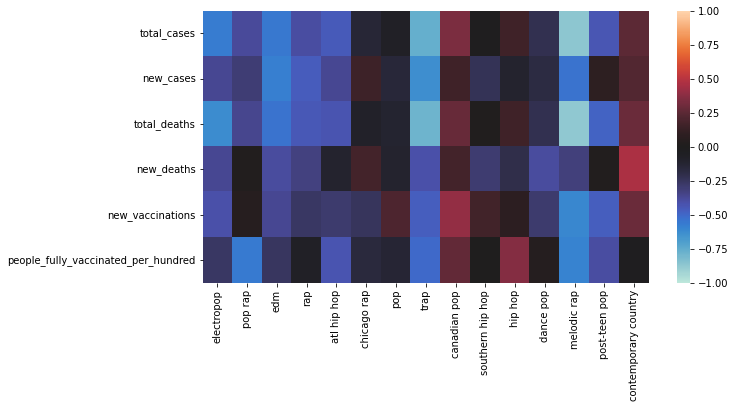

In [ ]:
# get unique categories
list_categories = genre_week_df.category.unique().tolist()
# relevant covid data columns
covid_cols = ['date','total_cases', 'new_cases', 'total_deaths', 'new_deaths', 'new_vaccinations', 'people_fully_vaccinated_per_hundred']
# expands categories into multiple columns so that they can be combined into one row
def expand_categories(x):
    # extract all fields except for category and normalized count
    row = x.drop_duplicates('total_cases').drop(columns=['category', 'norm_count'])
    # create a new column for each category and store its normalized count
    for i,item in x[['category','norm_count']].iterrows():
        row[item['category']] = item['norm_count']
    return row
# get correlation for genres vs the covid data
corr_df = cdf[covid_cols].merge(genre_week_df[['category','norm_count','week_date']],left_on='date', right_on='week_date').groupby('date').apply(expand_categories).dropna().corr()
# drop unneeded columns and rows to make the graph more readable
corr_df = corr_df.drop(index=list_categories, columns=covid_cols[1:])
# set plot size
fig, ax = plt.subplots(figsize=(10,5))
# plot heatmap of the correlation data
sns.heatmap(corr_df, cmap="icefire", vmin=-1, vmax=1, ax=ax)

In [ ]:
# Important dates on the Covid timeline from the US. Sourced from https://www.cdc.gov/museum/timeline/covid19.html
important_dates = [
    {'date': '2020-01-21', 'label': 'First Covid-19 case'},
    {'date': '2020-03-15', 'label': 'First states shutdown'},
    {'date': '2020-12-14', 'label': 'First public vaccination'},
    {'date': '2021-03-08', 'label': 'Vaccinated people can be without masks'}
] if country == 'us' else []

Then, we will graph the normalized popularity of each genre (blue line) along the with the number of new covid cases (red line) over time. The green dotted lines are event markers for important dates throughout CoVid-19.

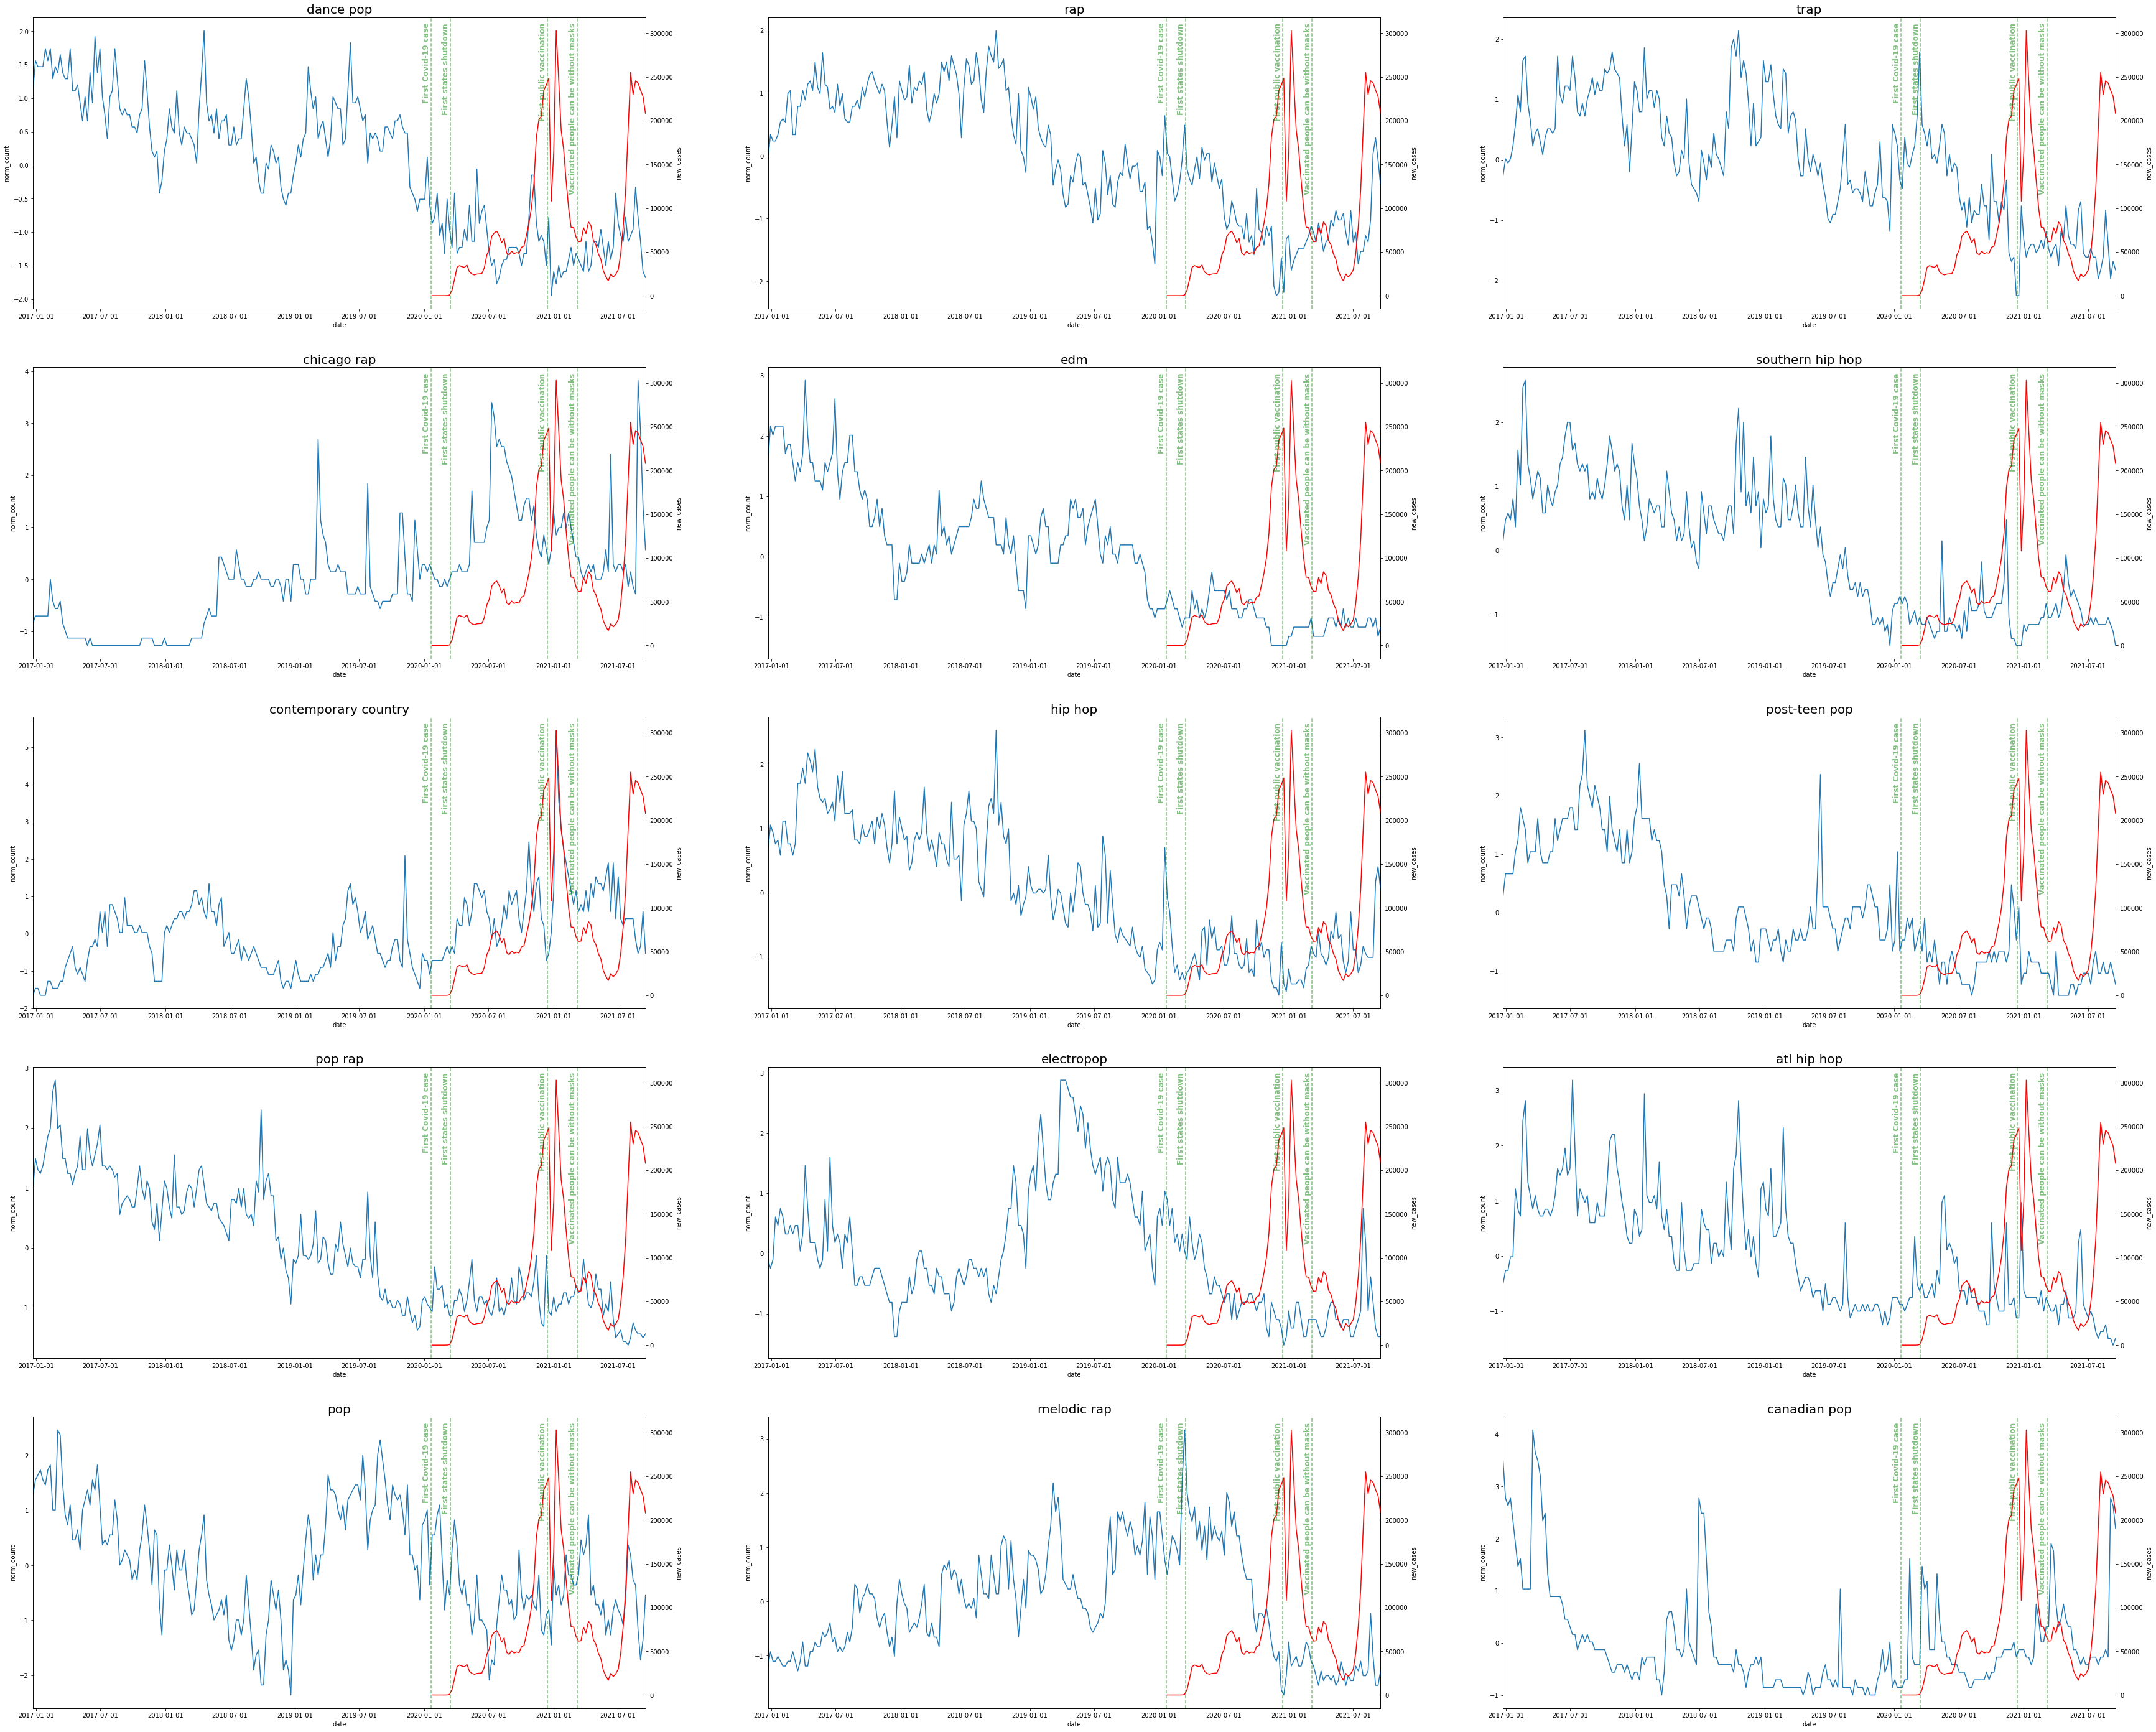

In [ ]:
# get genre data
data = genre_week_df
# get covid data that matches up within the timeline of the genre data
cdf = cdf[cdf.week_date_ord.isin(data.week_date_ord.unique().tolist())]
# make 15 subplots
fig, axes = plt.subplots(5,3, figsize=(60,50))
# loop through subplots
for i,ax in enumerate(axes.flatten()):
    # plot normalized count for the selected category
    sns.lineplot(x="week_date_ord", y="norm_count", data=data[data.category==selected_categories[i]], ax=ax)
    # add a second y axis that connects to the same x axis
    ax2 = ax.twinx()
    # plot covid data
    sns.lineplot(x="week_date_ord", y="new_cases", data=cdf, ax=ax2, color="r")
    # plot event markers
    for j,dt in enumerate(important_dates):
        ax2.axvline(pd.Timestamp(dt['date']), linestyle='--', color='green', alpha=.5)
        ax2.text(pd.Timestamp(dt['date'])-timedelta(days=24),ax2.get_ylim()[1]*.98,dt['label'],rotation=90, verticalalignment='top', fontsize='large', color='green', fontweight='demibold', alpha=.5)
    # set title to genre
    ax.set_title(selected_categories[i], fontdict={'fontsize': 20})
    # cut off blank areas on the both sides
    ax.set_xlim(data['week_date_ord'].min(), data['week_date_ord'].max())
    # label x axis as date
    ax.set_xlabel('date')
    # convert labels to a readable format in date time form
    new_labels = [date.fromordinal(int(item)) for item in ax.get_xticks()]
    ax.set_xticklabels(new_labels)
plt.show()

**Comparing impact on the listening pattern for different genres due to Covid-19 across the US:** <br>


---


From the graphs, we can infer that song genres `contemporary country` and `canadian pop` were having more active listeners when Covid-19 was at its peak.

Song genres like `rap`, `hip hop`, `southern hip hop`, `trap` and `dance pop` saw a huge decrease in their daily listeners count during the peak season of Covid-19.


Further we can also infer that the song genre `dance pop` which was poupular before Covid-19, plummented due to Covid-19 and still could not gain back the popularity.

**Comparing impact on the listening pattern for different genres due to various events during Covid-19 impact across the US:** <br>


---



To analyze the impact of various events during Covid-19, we have plotted the event markers for the following events:

*   First Covid-19 case
*   First states shutdown
*   First public vaccination
*   Vaccinated people can be without masks

Comparing `contemporary country` pattern with the event markers we can see that this genre saw the highest number of listeners after the first public vaccination started.

Another genre impacted is `electropop`, where the number of listeners to the song belonging to this genre started decreasing after the states started shutdown and started to increase after vaccinated people were allowed to be without masks.

Similar to `electropop`, `rap` saw its lowest listeners after the state's shutdown started and the pattern became normal after vaccinated people were allowed to be without masks.


<a name="5-B"></a>
### 5-B. Song features


Here, we plot the average audio analysis features (blue line) for each week charted and the number of new covid cases (red line) over time.

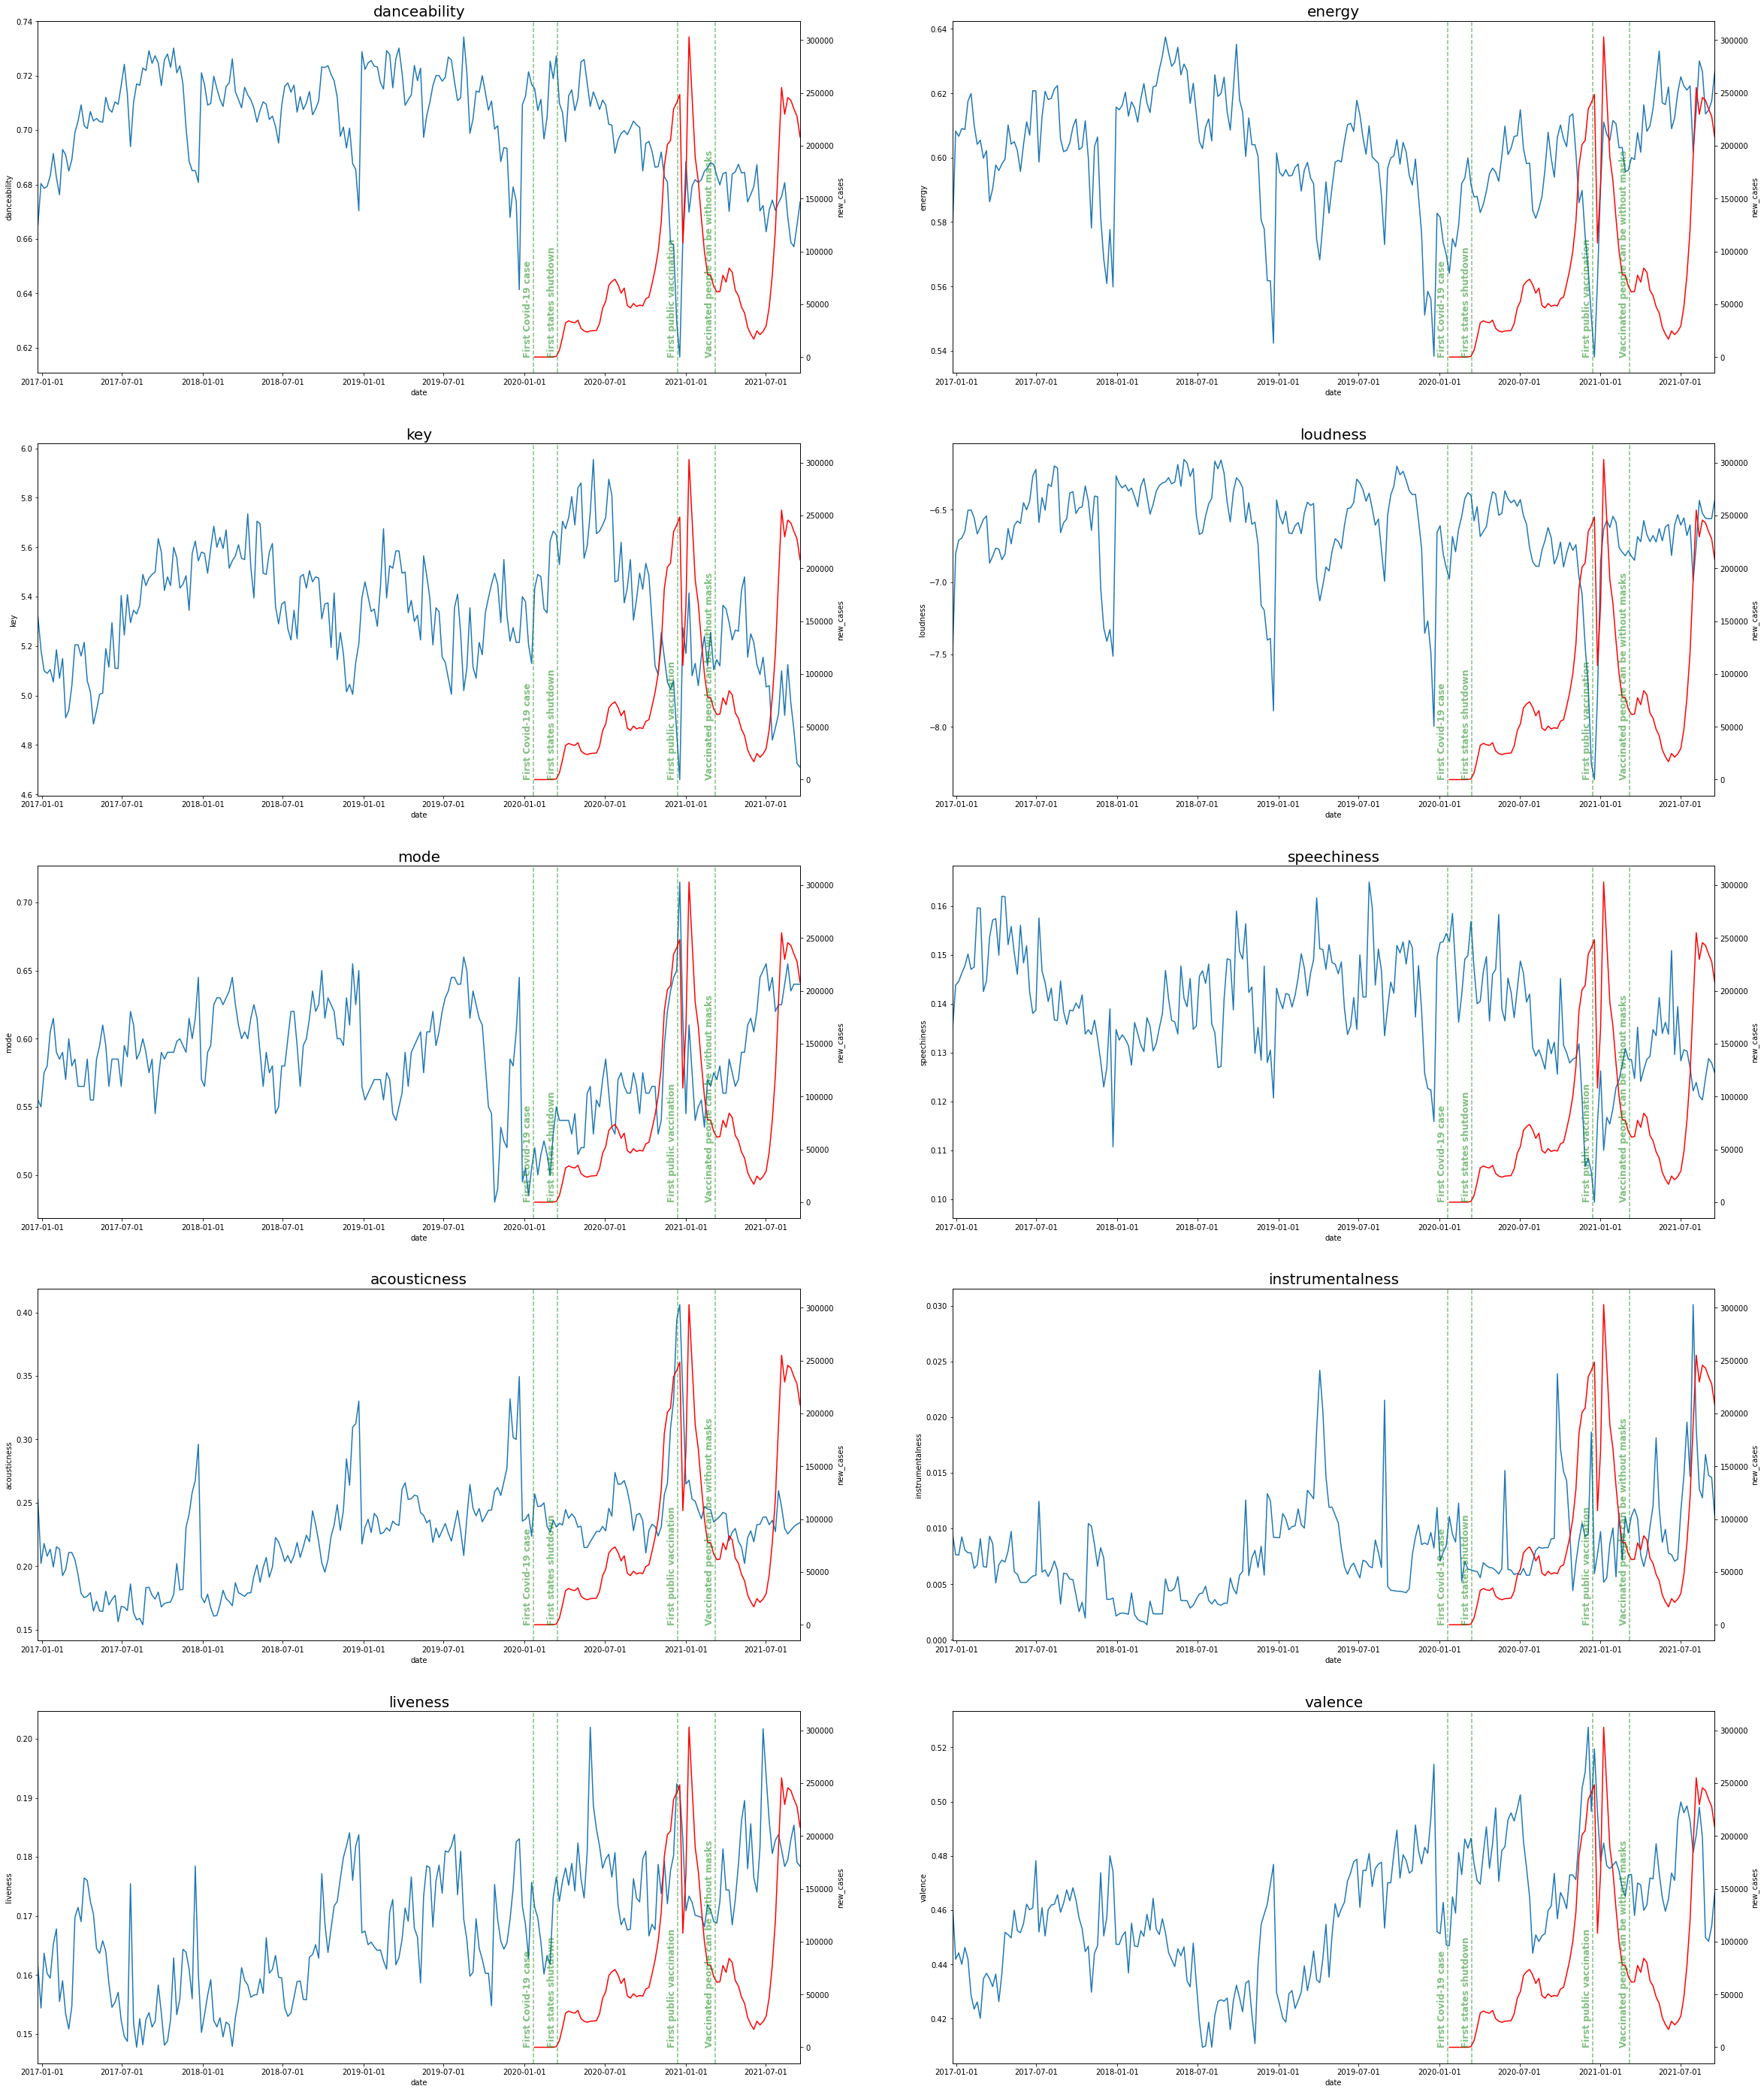

In [ ]:
# make 10 subplots
fig, axes = plt.subplots(5,2, figsize=(40,50))
# audio features to be plotted
feature_cols = ["danceability", "energy", "key", "loudness", "mode", "speechiness", "acousticness", "instrumentalness", "liveness", "valence"]
# store mean audio features per week
data = df.groupby('week_charted')[feature_cols].mean().reset_index()
# store week charted in a ordinal form for graphing
data['week_date_ord'] = data['week_charted'].apply(lambda date: date.toordinal())
# loop through subplots
for i,ax in enumerate(axes.flatten()):
    # plot selected audio feature
    sns.lineplot(x="week_date_ord", y=feature_cols[i], data=data, ax=ax)
    # add a second y axis that connects to the same x axis
    ax2 = ax.twinx()
    # plot covid data
    sns.lineplot(x="week_date_ord", y="new_cases", data=cdf, ax=ax2, color="r")
    # plot event markers
    for j,dt in enumerate(important_dates):
        ax2.axvline(pd.Timestamp(dt['date']), linestyle='--', color='green', alpha=.5)
        ax2.text(pd.Timestamp(dt['date'])-timedelta(days=24),0,dt['label'],rotation=90, verticalalignment='bottom', fontsize='large', color='green', fontweight='demibold', alpha=.5)
    # set title to the feature type
    ax.set_title(feature_cols[i], fontdict={'fontsize': 20})
    # remove extra space on the sides of the graph
    ax.set_xlim(data['week_date_ord'].min(), data['week_date_ord'].max())
    # label the x axis as date
    ax.set_xlabel('date')
    # convert labels to a readable format in date time form
    new_labels = [date.fromordinal(int(item)) for item in ax.get_xticks()]
    ax.set_xticklabels(new_labels)
plt.show()

**Analyzing the impact of Covid-19 on users preference of song using various song audio features:** <br>

---

* In the case of `danceability`, we noticed a reduction in the month of December prior to any new Covid-19 cases, but this has a substantial influence during Covid-19, with the increase in covid-19 cases Spotify users preferred listening to songs with lower `danceability`.
* In the case of the `key` audio feature, it was high in the beginning of Covid-19, but with the spike in Covid-19, the `key` audio feature has drastically decreased.
* When comparing the song's `energy` and `loudness` feature with Covid-19 cases, we found that before Covid-19, there was a decrease in the month of December every year (slightly around Christmas) and an increase after that. This means that songs having high `energy` and `loudness` feature were less preferred by the users. The similar pattern has been noticed after Covid-19, with a slight decrease in the month of December.
* Before Covid-19, the `speechiness` feature would decline in December and then increase, but we saw that with the increase in first Covid-19 cases, we saw the users preferred songs having the low `speechiness` value.
* Observed that the `acoustic` feature increases over time every year, but users preferred songs having increase in `acoustic` factor with the increases in new Covid-19 cases.
* There isn't much of a difference between before and after Covid-19, however with the first Covid-19 case, we noticed that users started listening to the songs having more `liveness` feature.
* With the rise and fall of Covid-19 cases, the `valance` song feature has no significant impact on listening preference of users.

<a name="5-C"></a>
### 5-C. Song's release date
Using the release dates of the songs, we made a graph showing the relation between the release date and the week charted.

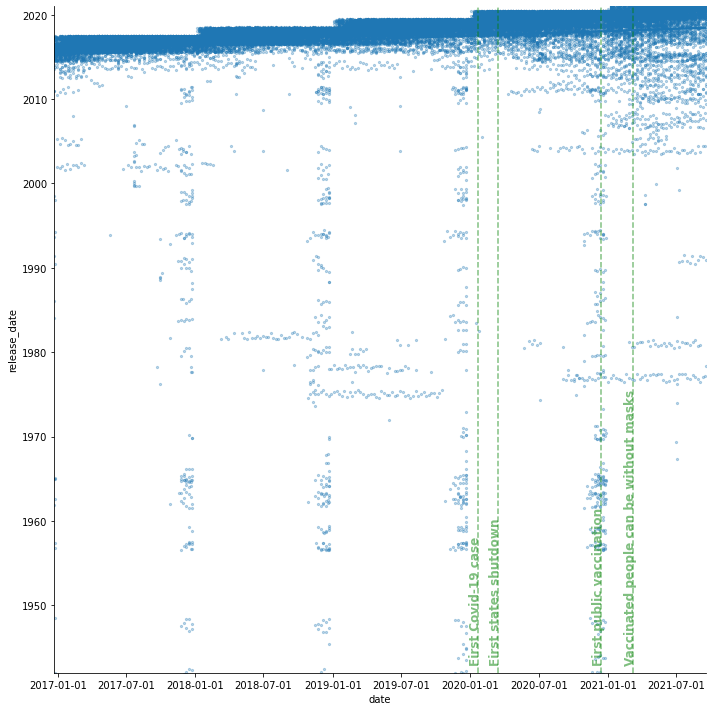

In [ ]:
import matplotlib
import matplotlib.pyplot as plt
data = df
# converted week charted to ordinal
data['week_date_ord'] = data['week_charted'].apply(lambda date: date.toordinal())
# convert release date from a str to an int
data['release_date'] = data.release_date.apply(lambda x: int(x))
# plot the data
g = sns.lmplot(x='week_date_ord', y='release_date', data=data, palette='tab10', height=10,x_jitter=.5, y_jitter=.5,scatter_kws={"alpha":.3,"s": 5})
for ax in g.axes.flat:
    # remove extra spaces from the sides of the graph
    ax.set_xlim(data['week_date_ord'].min(), data['week_date_ord'].max())
    ax.set_ylim(data['release_date'].min(), data['release_date'].max())
    # set the x axis label to date
    ax.set_xlabel('date')
    # plot event markers
    for j,dt in enumerate(important_dates):
        ax.axvline(pd.Timestamp(dt['date']), linestyle='--', color='green', alpha=.5)
        ax.text(pd.Timestamp(dt['date'])-timedelta(days=24),ax.get_ylim()[0]*1.0005,dt['label'],rotation=90, verticalalignment='bottom', fontsize='large', color='green', fontweight='demibold', alpha=.5)
    # convert labels to a readable format in date time form
    new_labels = [date.fromordinal(int(item)) for item in ax.get_xticks()]
    ax.set_xticklabels(new_labels)

**Analyzing the impact of Covid-19 to the user's preference of song (Old song vs New song):**

---

We observed that the users haven’t preferred listening to songs released in past 5 to 10 years before Covid-19. However, this has not changed regardless of new Covid-19 cases. The number of people listening to older music has increased after 2019 in general, this could be due to a work from home routine during lockdown.